# 📝 Pattern Recognition & Biometrics. TP Régression

Par Omar Galarraga et Sonia Garcia

L'objectif de ce travail pratique est de réaliser des tâches de régression : 

* Linéaire simple
* Multilinéaire (avec et sans régularisation)
* Non linéaire avec réseaux de neurones

Nous voudrons prédire le prix médian des maisons californiennes par quartier en fonction de plusieurs variables quantitatives. 

Commençons par charger les données et regarder la description de la base de données :


In [19]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

california_housing = fetch_california_housing(as_frame=True)

print(california_housing.frame.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


* 0.1) Montrez l'histogramme des variables (Piste : *california_housing.frame* contient un DataFrame de Pandas) 

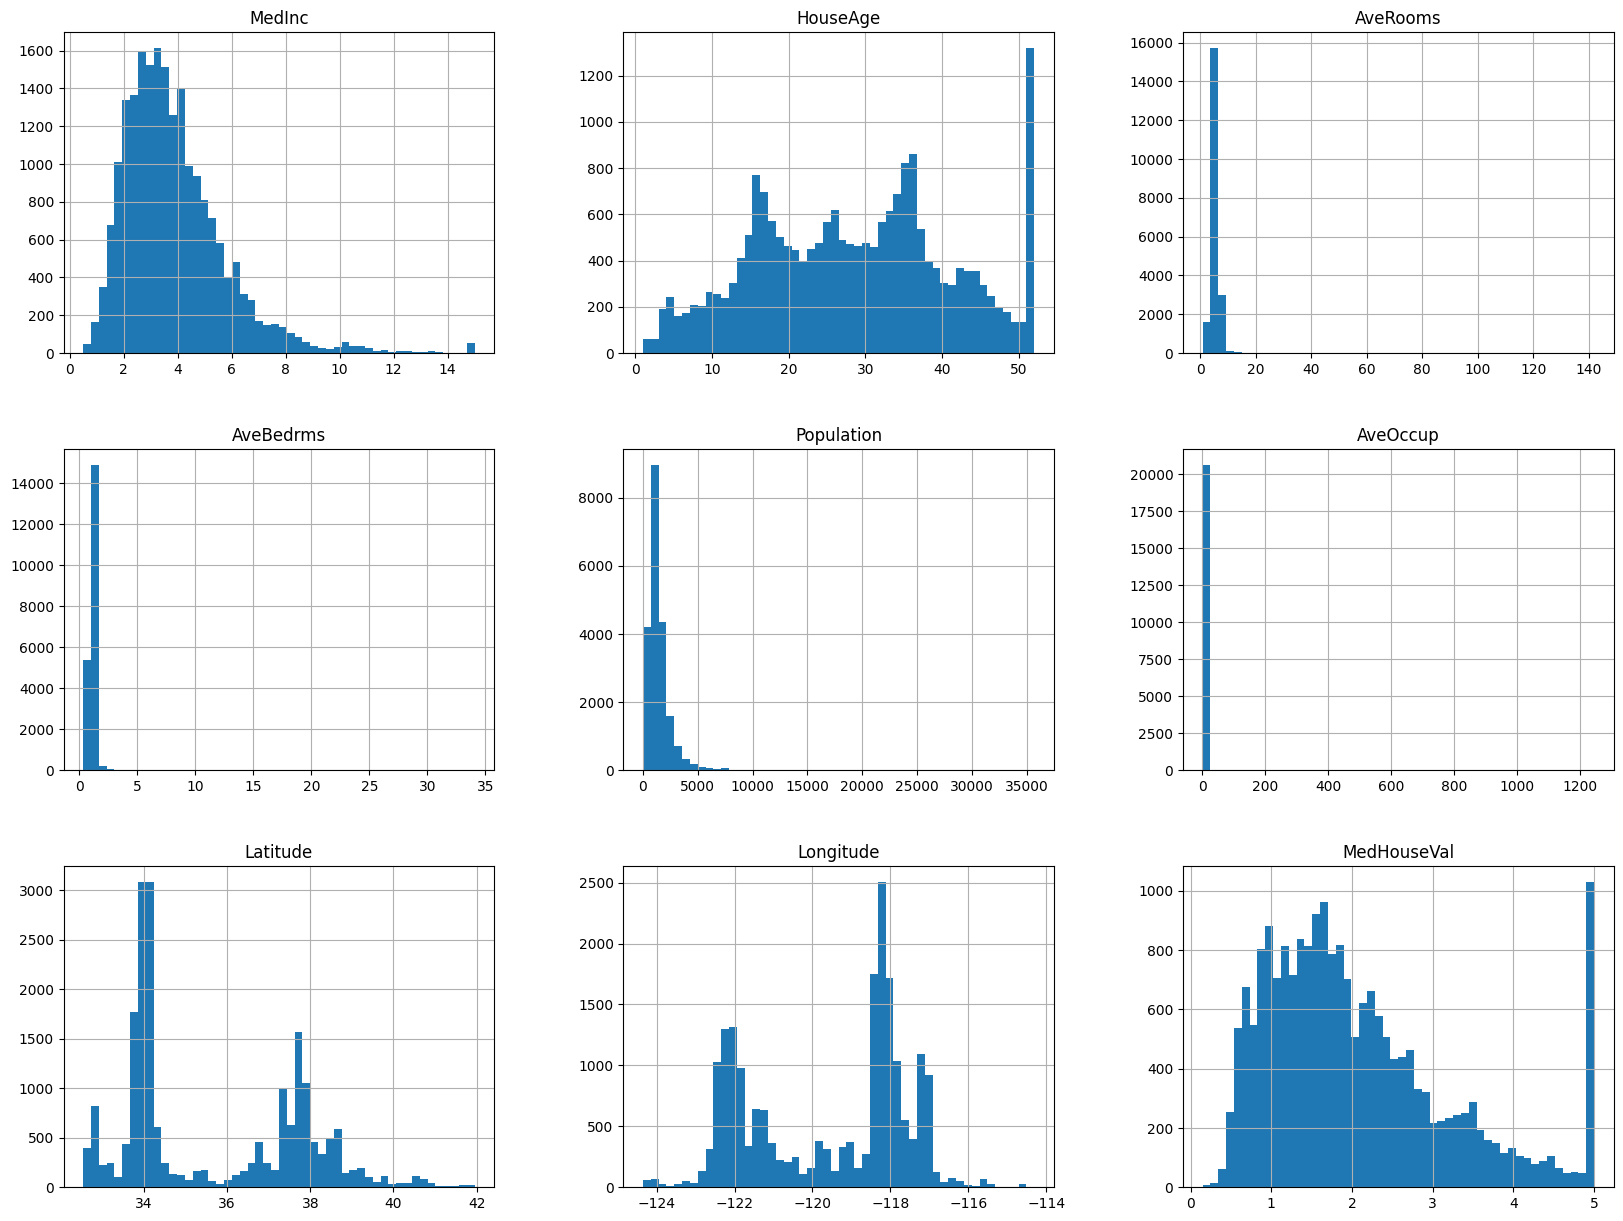

In [7]:

def plot_hist():
    california_housing.frame.hist(bins=50, figsize=(20,15))
    plt.show()
plot_hist()

## Partie I. Régression linéaire simple

Calculez la matrice de corrélations.

* I.1) Si vous deviez choisir une seule variable pour réaliser une régression linéaire simple, laquelle choisiriez-vous ? Pourquoi ? 

In [23]:
corr_matrix = california_housing.frame.corr()

best_one = corr_matrix["MedInc"].sort_values(ascending=False)
print(best_one)
# Choisir MedHouseVal car forte corrélation avec la target MedInc

MedInc         1.000000
MedHouseVal    0.688075
AveRooms       0.326895
AveOccup       0.018766
Population     0.004834
Longitude     -0.015176
AveBedrms     -0.062040
Latitude      -0.079809
HouseAge      -0.119034
Name: MedInc, dtype: float64

Nous voudrons créer un modèle $ \hat{y} = ax + b $, où $ \hat{y} $ est la prédiction du prix médian des maisons par quartier et $x$ est la caractéristique choisie en I.1.

* I.2) Quelles sont les valeurs optimales de $ a $ et $ b $ ? 

In [27]:
def moindre_carre_a_b(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    x_var = x.var()
    y_var = y.var()
    xy = x * y
    xy_mean = xy.mean()
    a = (xy_mean - x_mean * y_mean) / x_var
    b = y_mean - a * x_mean
    return a, b
x = california_housing.frame["MedHouseVal"]
y = california_housing.frame["MedInc"]
a,b = moindre_carre_a_b(x, y)
print("Notre modèle est y = {} * x + {}".format(a,b))

Notre modèle est y = 1.132761309380062 * x + 1.5274883427607309


* I.3) Quelle est la valeur de $R^2$ ? Est-ce un bon ajustement ? Commentez
* I.4) Tracez la courbe de régression sur le nuage de points entre la sortie désirée et l'entrée

In [31]:
def calculate_r2(x, y, a, b):
    y_mean = y.mean()
    y_pred = a * x + b
    ss_res = ((y - y_pred) ** 2).sum()
    ss_tot = ((y - y_mean) ** 2).sum()
    return 1 - ss_res / ss_tot

r2 = calculate_r2(x, y, a, b)
print(r2)

# On obtient un R2 de 0.47, ce qui est assez faible. On peut donc dire que notre modèle n'est pas très bon.

0.473447490695845


* I.5) Quelle est l'erreur RMS de prédiction ? (en moyenne sur toutes les observations)

In [32]:
calculate_RMS = lambda x, y, a, b: ((y - a * x - b) ** 2).mean() ** 0.5
RMS = calculate_RMS(x, y, a, b)
print(RMS)

1.378552056492421


## Partie II. Régression multilinéaire

Maintenant réalisez une régression linéaire en utilisant toutes les caractéristiques disponibles. 

* II.1) Quelle est l'erreur de prédiction ?
* II.2) Quelle est la valeur de $R^2$ ? L'ajustement est-il meilleur qu'avec une seule variable d'entrée ?
* II.3) Quels sont les coefficients associés aux variables d'entrée, ainsi que le terme indépendant ?

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = california_housing.frame["MedInc"]

def multilinear_regression():
    X = california_housing.frame.drop("MedInc", axis=1)
    y = california_housing.frame["MedInc"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    lin_mse = mean_squared_error(y_test, y_pred)
    lin_rmse = lin_mse ** 0.5
    print("Linear regression RMSE: ", lin_rmse)
    print("Linear regression R2: ", lin_reg.score(X_test, y_test))

multilinear_regression()

#On a un R2 plus proche de 1 et un RMSE plus proche de 0 avec la régression linéaire multiple. On peut donc dire que ce modèle est meilleur que le précédent. Cependant
#on peut encore l'améliorer en utilisant un modèle plus complexe.

Linear regression RMSE:  1.051570247066906
Linear regression R2:  0.6875602314945066


Maintenant nous allons introduire un terme de régularisation, donc la nouvelle fonction de coût est : $$ J' = J + \alpha\sum_{i}{w_i^2} $$
* II.4) Quelle est la valeur optimale du paramètre $\alpha$ ? (Trouvez-la empiriquement) 
* II.5) Quelle est l'erreur RMS avec $\alpha$ optimal ?

In [ ]:
#Ecrivez votre code ici

Ajoutez des variables polynomiales d'ordre $o=2$ aux variables déjà disponibles. Comparez la régression avec et sans régularisation (RMSE, $R^2$)
* II.6) Laquelle donne des meilleurs résultats ? Pourquoi ?  

In [ ]:
#Ecrivez votre code ici

## Partie III. Régression non linéaire avec réseaux de neurones

Construisez et entraînez un réseau de neurones type Perceptron Multicouche (PMC) à $N_{layer} = 3$ couches et avec $m=5$ neurones dans la couche cachée.

N'oubliez pas de normaliser les données en prétraitement. 

In [ ]:
#Ecrivez votre code ici


* III.1) Quelle sont les prix prédits pour les dix premières observations ?
* III.2) Quelle est l'erreur RMS d'apprentissage ?

In [ ]:
#Ecrivez votre code ici

Réalisez une validation croisée type *K-Fold* avec $K=10$ (n'oubliez pas de mélanger les données préalablement)

* III.3) Quelle sont les erreurs RMS d'apprentissage et de test ? (Moyenne et écart-type)

In [ ]:
#Ecrivez votre code ici

Optimisez le nombre de neurones $m$ dans la couche cachée (Piste : réalisez la validation croisée pour différentes valeurs de $m$)

* III.4) Quelle est la valeur optimale de $m$ ? Pourquoi ? 

In [ ]:
#Ecrivez votre code ici

Pour une validation-croisée type K-Fold avec $K=10$ (mélangez l'ordre des observations), remplissez le tableau de RMSE de test ci-dessous selon les différents types de régression.

| Type de régression | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Fold 6 | Fold 7 | Fold 8 | Fold 9 | Fold 10 |
|--------------------|---------|--------|--------|-------|--------|-------|---------|--------|--------|---------|
| Linéaire simple    |  |  |  |  |  |  |  |  |  |  |
| Multilinéaire sans régul.    |  |  |  |  |  |  |  |  |  |  |
| Multilinéaire avec régul.    |  |  |  |  |  |  |  |  |  |  |
| Polynomiale sans régul.    |  |  |  |  |  |  |  |  |  |  |
| Polynomiale avec régul.    |  |  |  |  |  |  |  |  |  |  |
| Non linéaire avec NN    |  |  |  |  |  |  |  |  |  |  |

* III.5) Quelle est la méthode de régression la plus adaptée pour ce problème ? Justifiez
